In [1]:
import os
import mne
import random
import re
import shutil

import numpy as np
import pandas as pd
import scikitplot as skplt
import scipy.io as io
import tensorflow as tf


from pywt import wavedec
from sklearn.model_selection import train_test_split
from tensorflow import keras
from typing import List

2022-05-21 13:41:31.330872: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-21 13:41:31.452883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-21 13:41:31.452900: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filename = "resources/dane_eeg.zip"
extract_dir = "resources/dane_eeg"
seizure_occ_file = "resources/dane_eeg/czasy_napadow.m"
healthy_dir = "resources/dane_eeg/zdrowi"
unhealthy_dir = "resources/dane_eeg/chorzy"
img_dir = "resources/dane_eeg/images/"

# shutil.unpack_archive(filename, extract_dir)

In [3]:
def get_mat_files(base_path): 
    mat_files_list = []
    filenames = {}

    for file in os.listdir(base_path):
        if file.endswith(".mat"):
            mat_files_list.append(base_path + "/" + file)
            
    for filename in mat_files_list:        
        filenames[filename.split('/')[-1].split('_')[0]] = filename
        
    return mat_files_list, filenames


healthy_paths, healthy_patients_dict = get_mat_files(healthy_dir)
unhealthy_paths, unhealthy_patients_dict = get_mat_files(unhealthy_dir)

In [4]:
def get_all_seizure_occurrences(file_path):
    all_occurrences = {}
    with open (file_path , 'r') as file:
        for line in file :
            line_number = int(re.search(r'{([0-9]+)}', line).group(1))
            occ_list = list(map(int, re.search(r'\[(.+?)]', line).group(1).split()))
            all_occurrences[line_number] = occ_list
    return all_occurrences


seizure_occurrences = get_all_seizure_occurrences(seizure_occ_file)

In [5]:
class Seizure:
    def __init__ (self, id, filename, samples, seizure_occurrences=None, frequency=100, channels=16) -> None :
        super (). __init__ ()
        self.id = id
        self.filename = filename
        self.samples = samples
        self.seizure_occurrences = seizure_occurrences
        self.frequency = frequency
        self.channels = channels

In [6]:
def healthy_patients(healthy_people_dict):
    healthy_patients = []
    for id, path in healthy_people_dict.items():
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        healthy_patients.append(Seizure(id, filename, samples))
 
    return healthy_patients

def unhealthy_patients(unhealthy_people_dict, seizure_occurrences):
    unhealthy_patients = []
    for id, path in unhealthy_people_dict.items():
        seizure_occ = seizure_occurrences[int(id)]
        samples = io.loadmat(path)['x']
        filename = os.path.basename(path)
        unhealthy_patients.append(Seizure(id, filename, samples, seizure_occurrences=seizure_occ))
 
    return unhealthy_patients

In [7]:
healthy_list: List[Seizure] = healthy_patients(healthy_patients_dict)
unhealthy_list: List[Seizure] = unhealthy_patients(unhealthy_patients_dict, seizure_occurrences)

In [8]:
# def saveToPng(figure, filename, img_dir, seizure_time):
#     base_filename = os.path.splitext(filename)[0]
#     dir_name = img_dir + base_filename
#     if not os.path.exists(dir_name):
#         os. makedirs(dir_name)
#     figure.savefig(dir_name + '/' + base_filename + str(seizure_time) + '.png')


# def plot_all_attacks(unhealthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def create_annotations(occurrences):
#         events = [x for x in occurrences ]
#         return mne.Annotations(onset=events, duration=2, description=['seizure ' + str(x) for x in occurrences])

#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)
            
# def plot_healthy(healthy_people, save_to_png=False, img_dir=""):
#  # colored blocks for visualization of attack
#     def visualize(filename, samples, seizure_time, all_events, save_to_png):
#         ch_names = list(map(str,range(1,17))) 
#         info = mne.create_info(ch_names=ch_names, sfreq =100)
#         raw = mne.io.RawArray(np.transpose(samples), info)
#         raw.set_annotations(all_events)

#         figure = raw.plot(n_channels=16, scalings='auto', title=filename + 'Time_of_seizure: ' + str(seizure_time), block=False, start=max(0, seizure_time - 5), duration=10)
 
#         if save_to_png:
#             saveToPng(figure, filename, img_dir, seizure_time)

#     for person in unhealthy_people:
#         all_events = create_annotations(person.seizure_occurrences)
#         for seizure_time in person.seizure_occurences:
#             visualize(person.filename, person.samples, seizure_time, all_events, save_to_png)

In [9]:
# plot_all_attacks(unhealthy_list, save_to_png = True, img_dir=img_dir)
# list(map(str,range(1,17))) 

In [10]:
# def plot_seizures_of_patient(unhealthy_people, patient_nr, channels_no =1):
#     patient = next((x for x in unhealthy_people if x.id == str(patient_nr)), 0)
#     info = mne.create_info(ch_names = list(map(str,range(1,17))), sfreq = 100, ch_types ='eeg')
#     raw = mne.io.RawArray(np.transpose(patient.samples), info)
#     annot = mne.Annotations(onset = patient.seizure_matches, duration = 2, description = patient.seizure_matches) 
#     raw.set_annotations(annot)
#     plot_kwargs = {
#         'scalings': dict(eeg=30),
#         'highpass': 1,
#         'lowpass': 40,
#         'n_channels': channels_no,
#         'duration': 10,
#     }

#     for seizure in patient.seizure_occurences:
#         raw.plot(**plot_kwargs, start = seizure - 2)

In [11]:
for patient in healthy_list:
    patient.samples = np.delete(patient.samples, -1, axis =1)

In [12]:
healthy_epochs = []
for patient in healthy_list:
  samples = patient.samples
  for i in range(0, samples.shape[0] - 100, 200):
    chunk = samples[i:i + 200]
    healthy_epochs.append(('healthy', chunk))


unhealthy_epochs = []
for patient in unhealthy_list:
    samples = patient.samples
    for seizure_time in patient.seizure_occurrences:
        seizure_start = seizure_time * 100
        chunk = samples[seizure_time:seizure_time + 200]
        unhealthy_epochs.append(('unhealthy', chunk))


chunks_healthy_from_sick = []
for patient in unhealthy_list:
    samples = patient.samples
    occurrences = patient.seizure_occurrences
    indexes = [i * 100 for i in occurrences]

    # divide by seizure matches
    chunks = np.split(samples, indexes)
    chunks_healthy = [chunks[0][: -400]]

     # remove 4 seconds of potential seizure from each chunk
    for element in chunks [1:]:
        chunks_healthy.append(element[400:])

     # split each chunk for healthy waves
        for e in chunks_healthy:
            for i in range(0, e.shape [0] - 100, 200):
                chunk = e[i:i + 200]
                chunks_healthy_from_sick.append(('healthy', chunk))

In [25]:
true_healthy = random.sample(healthy_epochs, 3000)
# len(healthy_epochs)
all_epochs = true_healthy + unhealthy_epochs
# all_epochs = healthy_epochs + unhealthy_epochs
len(all_epochs)

3588

In [26]:
def wavelet_decompose_channels(data, level):
#     data = data[0::2]
    data.columns.name ='channel'
    data_t = data.transpose()

    coeffs_list = wavedec(data_t.values, wavelet ='db4', level = level)

    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[ -1]))

    # reverse the names
    names = names[:: -1]
    wavelets = pd.DataFrame()

    for i, array in enumerate(coeffs_list):
        lvl_df = pd.DataFrame(array)
        lvl_df.index = data.columns
        lvl_df['level'] = names[i]
        lvl_df = lvl_df.set_index('level', append = True)
        lvl_df = lvl_df.T
        wavelets = pd.concat([ wavelets, lvl_df ], axis=1, sort = True)

    wavelets = wavelets.sort_values(['channel','level'], axis=1)

    to_be_dropped = [x for x in list(wavelets.columns.levels[1]) if not re.compile('D').match(x)]
    decom_wavelets = wavelets.drop(to_be_dropped, axis=1, level ='level')

    decom_wavelets.index.name ='sample'

    return decom_wavelets


class Feature:
    def __init__(self, max, min, mean, std, mean_abs) -> None:
        super().__init__()
        self.max = max
        self.min = min
        self.mean = mean
        self.std = std
        self.mean_abs = mean_abs

    def getall(self):
        import itertools
        return list(itertools.chain(self.max, self.min, self.mean, self.std, self.mean_abs))

all_label_features = []


def get_features(data):
    max_data = data.max().to_numpy()
    min_data = data.min().to_numpy()
    mean_data = data.mean().to_numpy()
    std_data = data.std().to_numpy()
    mean_abs_data = data.abs().mean().to_numpy()

    return Feature(max_data, min_data, mean_data, std_data, mean_abs_data)


for epoch in all_epochs:
    wavelet = wavelet_decompose_channels(pd.DataFrame(epoch[1]), level=4)
    features = get_features(wavelet)
    all_label_features.append((epoch[0], features))

In [64]:
def wavelet_decompose_channels(data, level):
#     data = data[0::2]
    data.columns.name ='channel'
    data_t = data.transpose()

    coeffs_list = wavedec(data_t.values, wavelet = 'db4', level = level)
    
    print(len(coeffs_list))

    nums = list(range(1, level + 1))
    names = []
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[ -1]))

    
    # reverse the names
    names = names[:: -1]
    wavelets = pd.DataFrame()
    
    for index, array in enumerate(coeffs_list):
        lvl_df = pd.DataFrame(array)
        lvl_df.index = data.columns
        lvl_df['level'] = names[index]
        lvl_df = lvl_df.set_index('level', append = True)
        lvl_df = lvl_df.T
        wavelets = pd.concat([wavelets, lvl_df], axis=1, sort = True)

    wavelets = wavelets.sort_values(['channel','level'], axis=1)

    to_be_dropped = [x for x in list(wavelets.columns.levels[1]) if not re.compile('D').match(x)]
    decom_wavelets = wavelets.drop(to_be_dropped, axis=1, level ='level')

    decom_wavelets.index.name ='sample'

    return decom_wavelets

epoch = all_epochs[1]
wavelet_decompose_channels(pd.DataFrame(epoch[1]), 4)

5


channel        0                                       1                       \
level          D1        D2        D3        D4        D1        D2        D3   
sample                                                                          
0        0.305154  0.148685  0.506826 -0.022565 -0.055595  1.059009 -0.765153   
1        0.560035  0.552247  1.482142 -0.257791 -0.405141  3.341882 -2.546086   
2       -0.801948 -0.342148 -2.665924 -1.131782  0.451552 -0.473236 -1.115737   
3        1.125893  2.147450 -4.508748 -0.690102  0.000796  3.623554  1.770020   
4       -1.333761  1.214671  3.965389  6.521918  0.199388 -0.907313  0.010435   
...           ...       ...       ...       ...       ...       ...       ...   
98       0.119774       NaN       NaN       NaN  0.022597       NaN       NaN   
99      -0.258076       NaN       NaN       NaN  0.499681       NaN       NaN   
100      0.106235       NaN       NaN       NaN -0.201835       NaN       NaN   
101      0.109148       NaN       NaN       NaN -0.483742       NaN       NaN   
102     -0.254583       NaN       NaN       NaN  0.388260       NaN       NaN   

channel                  2             ...         13                  14  \
level          D4        D1        D2  ...         D3        D4        D1   
sample                                 ...                                  
0       -0.093639 -0.027228  2.214085  ...   4.158767 -0.427489 -0.281355   
1       -0.319909 -0.562010  7.461451  ...  13.088149 -1.661908 -0.726763   
2       -1.245394  0.935165 -0.966706  ...  -4.396033  0.878444  0.801669   
3       -2.617879  0.102227  0.548288  ... -20.353056  2.888082 -0.043046   
4        4.804383 -0.609802 -1.299963  ...  -6.824254  2.114056  0.090054   
...           ...       ...       ...  ...        ...       ...       ...   
98            NaN -0.450535       NaN  ...        NaN       NaN -0.717834   
99            NaN  1.143588       NaN  ...        NaN       NaN  1.749739   
100           NaN -0.452360       NaN  ...        NaN       NaN -0.900064   
101           NaN -0.985022       NaN  ...        NaN       NaN -1.061159   
102           NaN  0.905713       NaN  ...        NaN       NaN  1.114711   

channel                                       15                        \
level          D2         D3        D4        D1         D2         D3   
sample                                                                   
0        1.571872  -0.553322 -0.081583 -0.620457   3.840151  -3.314117   
1        4.893250  -2.059232 -0.605168 -0.931310  11.514529 -11.404039   
2       -2.618725  -4.875869 -6.049219  1.784200  -9.920415 -11.356272   
3        3.614948   4.241776 -2.639494  0.229989  11.410264   1.100067   
4       -4.309747  11.125750  2.097512 -1.798425  -4.591981  11.509190   
...           ...        ...       ...       ...        ...        ...   
98            NaN        NaN       NaN -2.042971        NaN        NaN   
99            NaN        NaN       NaN  2.247823        NaN        NaN   
100           NaN        NaN       NaN -0.843749        NaN        NaN   
101           NaN        NaN       NaN -1.164479        NaN        NaN   
102           NaN        NaN       NaN  2.126372        NaN        NaN   

channel             
level           D4  
sample              
0         0.056693  
1        -0.328835  
2       -10.190089  
3         9.156764  
4         5.325477  
...            ...  
98             NaN  
99             NaN  
100            NaN  
101            NaN  
102            NaN  

[103 rows x 64 columns]

In [27]:
r_state = np.random.RandomState()

def convert_y_to_number(str):
    return 1.0 if str == 'unhealthy' else 0.0

X = np.array(list(x[1].getall() for x in all_label_features)) # data
y = np.array(list(convert_y_to_number(x[0]) for x in all_label_features)) # labels

X_r = np.reshape(X, (X.shape[0], X.shape[1], 1))
y_r = np.reshape(y, (y.shape[0], 1))
# X = np.array(list(x[1] for x in all_epochs))
# y = np.array(list(convert_y_to_number(x[0]) for x in all_epochs))

X_train , X_test , y_train , y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=r_state, shuffle=True)

In [28]:
count_0 = 0
count_1 = 1
for x in y_train:
    if x==0:
        count_0 += 1
    elif x==1:
        count_1 += 1

(count_0/y_train.shape[0])*100, (count_1/y_train.shape[0])*100

(83.65853658536585, 16.376306620209057)

In [29]:
X.shape

(3588, 320)

In [36]:
from tensorflow.keras.backend import clear_session
# model_1d = keras.models.Sequential([
#  keras.layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding="same", input_shape=(240, 1)),
#  keras.layers.MaxPooling1D(pool_size=5),
#  keras.layers.Flatten(),
#  keras.layers.Dense(128, activation="relu"),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(64, activation="relu"),
#  keras.layers.Dropout(0.5),
#  keras.layers.Dense(2, activation="softmax")
# ])
# def evaluate_model(X_train, y_train, X_test, y_test):
#     verbose, epochs, batch_size = 1, 10, 32
#     n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
#     model_1d = keras.models.Sequential()
#     model_1d.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(240, 1)))
#     model_1d.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
#     model_1d.add(keras.layers.Dropout(0.5))
#     model_1d.add(keras.layers.MaxPooling1D(pool_size=2))
#     model_1d.add(keras.layers.Flatten())
#     model_1d.add(keras.layers.Dense(100, activation='relu'))
#     model_1d.add(keras.layers.Dense(n_outputs, activation='softmax'))
#     model_1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model_1d.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
#     _, accuracy = model_1d.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
#     return accuracy

from tensorflow.keras.backend import clear_session


def evaluate_model(X_train, y_train, X_test, y_test, verbose=1, epochs=10, batch_size=32):
    clear_session()
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model_1d = keras.models.Sequential()
#     model_1d.add(keras.layers.Conv1D(filters=5, kernel_size=3, strides=1, input_shape=(240,1))) #n_timesteps,n_features
    model_1d.add(keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, input_shape=(n_timesteps,n_features))) #
    model_1d.add(keras.layers.BatchNormalization())
    model_1d.add(keras.layers.LeakyReLU())
    model_1d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d.add(keras.layers.Conv1D(filters=128, kernel_size=3, strides=1))
    model_1d.add(keras.layers.LeakyReLU())
    model_1d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_1d.add(keras.layers.Dropout(0.5))
    model_1d.add(keras.layers.Conv1D(filters=256, kernel_size=3, strides=1))
    model_1d.add(keras.layers.LeakyReLU())
    model_1d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d.add(keras.layers.Dropout(0.5))
    model_1d.add(keras.layers.Conv1D(filters=512, kernel_size=3, strides=1))
    model_1d.add(keras.layers.LeakyReLU())
    model_1d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_1d.add(keras.layers.Conv1D(filters=1024, kernel_size=3, strides=1))
    model_1d.add(keras.layers.LeakyReLU())
    model_1d.add(keras.layers.GlobalAveragePooling1D())
    model_1d.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    model_1d.compile('sgd', loss='binary_crossentropy', metrics=['accuracy'])
    history = model_1d.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)
    _, accuracy = model_1d.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return history, model_1d


In [37]:
history_1d, model_1d = evaluate_model(X_train, y_train, X_test, y_test, epochs=50)

Epoch 1/50
81/81 [==============================] - 5s 52ms/step - loss: 0.5750 - accuracy: 0.8250 - val_loss: 0.5593 - val_accuracy: 0.8502
Epoch 2/50
81/81 [==============================] - 4s 49ms/step - loss: 0.5297 - accuracy: 0.8351 - val_loss: 0.5264 - val_accuracy: 0.8502
Epoch 3/50
81/81 [==============================] - 4s 50ms/step - loss: 0.4969 - accuracy: 0.8351 - val_loss: 0.4851 - val_accuracy: 0.8467
Epoch 4/50
81/81 [==============================] - 4s 49ms/step - loss: 0.4602 - accuracy: 0.8362 - val_loss: 0.4408 - val_accuracy: 0.8467
Epoch 5/50
81/81 [==============================] - 4s 50ms/step - loss: 0.4254 - accuracy: 0.8401 - val_loss: 0.4128 - val_accuracy: 0.8467
Epoch 6/50
71/81 [=========================>....] - ETA: 0s - loss: 0.3959 - accuracy: 0.8429

KeyboardInterrupt: 

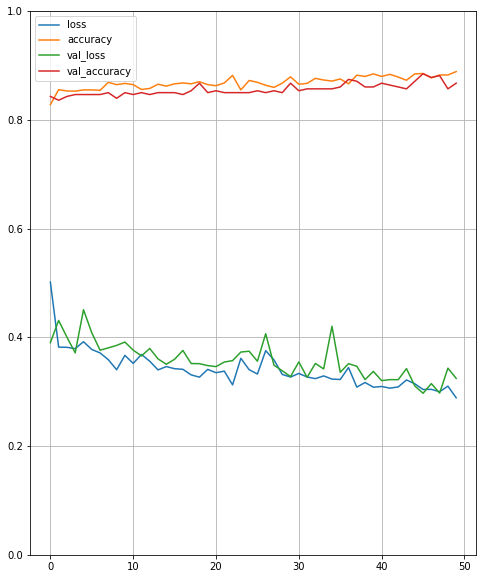

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history_1d.history).plot(figsize=(8, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Wyznacza zakres osi pionowej od 0 do 1
plt.show()

In [34]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_timesteps,n_features]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(n_outputs, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)

Epoch 1/30
81/81 [==============================] - 1s 3ms/step - loss: 1.9912 - accuracy: 0.7685 - val_loss: 0.4724 - val_accuracy: 0.8502
Epoch 2/30
81/81 [==============================] - 0s 2ms/step - loss: 0.5566 - accuracy: 0.8219 - val_loss: 0.3795 - val_accuracy: 0.8606
Epoch 3/30
81/81 [==============================] - 0s 2ms/step - loss: 0.5261 - accuracy: 0.8362 - val_loss: 0.3616 - val_accuracy: 0.8641
Epoch 4/30
81/81 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.8436 - val_loss: 0.4926 - val_accuracy: 0.8537
Epoch 5/30
81/81 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.8637 - val_loss: 0.5350 - val_accuracy: 0.8537
Epoch 6/30
81/81 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.8715 - val_loss: 0.3492 - val_accuracy: 0.8780
Epoch 7/30
81/81 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8866 - val_loss: 0.3518 - val_accuracy: 0.8815
Epoch 8/30
81/81 [==

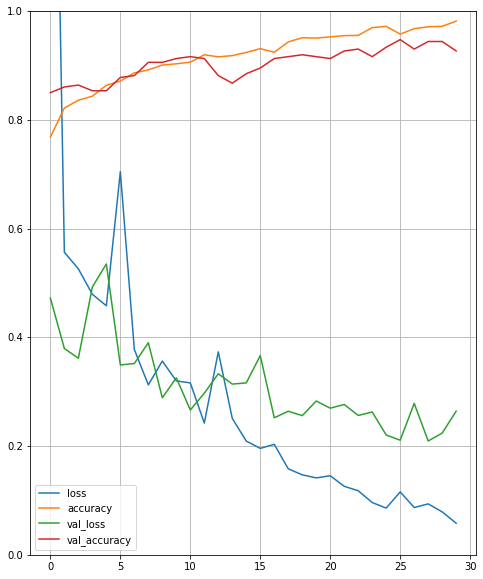

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1) # Wyznacza zakres osi pionowej od 0 do 1
plt.show()

In [61]:
def evaluate_model_2d(X_train, y_train, X_test, y_test, verbose=1, epochs=10, batch_size=32):
    clear_session()
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model_2d = keras.models.Sequential()
#     model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, input_shape=(240,1))) #n_timesteps,n_features
    model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, input_shape=(n_timesteps,n_features))) #
    model_2d.add(keras.layers.BatchNormalization())
    model_2d.add(keras.layers.LeakyReLU())
    model_2d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
    model_2d.add(keras.layers.LeakyReLU())
    model_2d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
    model_2d.add(keras.layers.Dropout(0.5))
    model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
    model_2d.add(keras.layers.LeakyReLU())
    model_2d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_2d.add(keras.layers.Dropout(0.5))
    model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
    model_2d.add(keras.layers.LeakyReLU())
    model_2d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
    model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
    model_2d.add(keras.layers.LeakyReLU())
    model_2d.add(keras.layers.GlobalAveragePooling1D())
    model_2d.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
    model_2d.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model_2d.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)
    _, accuracy = model_2d.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return history, model_2d

In [63]:
history_2d, model_2d = evaluate_model_2d(X_train, y_train, X_test, y_test)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 320, 1)

In [65]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
model_2d = keras.models.Sequential()
#     model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, input_shape=(240,1))) #n_timesteps,n_features
model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, input_shape=(320,2,1))) #
model_2d.add(keras.layers.BatchNormalization())
model_2d.add(keras.layers.LeakyReLU())
model_2d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
model_2d.add(keras.layers.LeakyReLU())
model_2d.add(keras.layers.MaxPool1D(pool_size=2, strides=2))
model_2d.add(keras.layers.Dropout(0.5))
model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
model_2d.add(keras.layers.LeakyReLU())
model_2d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
model_2d.add(keras.layers.Dropout(0.5))
model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
model_2d.add(keras.layers.LeakyReLU())
model_2d.add(keras.layers.AveragePooling1D(pool_size=2, strides=2))
model_2d.add(keras.layers.Conv2D(filters=5, kernel_size=3, strides=1))
model_2d.add(keras.layers.LeakyReLU())
model_2d.add(keras.layers.GlobalAveragePooling1D())
model_2d.add(keras.layers.Dense(n_outputs, activation="sigmoid"))
model_2d.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

ValueError: Exception encountered when calling layer "conv2d_2" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_2/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_2/Conv2D/ReadVariableOp)' with input shapes: [?,320,2,1], [3,3,1,5].

Call arguments received by layer "conv2d_2" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 320, 2, 1), dtype=float32)

In [22]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

def search_for_best_parameter(classifier, parameters, scoring):
    clf = GridSearchCV(classifier, parameters, n_jobs=-1, cv=3, scoring=scoring)
    clf.fit(X_train, y_train)

    print('Best parameters found :\n', clf.best_params_)

scores = ['balanced_accuracy', 'precision', 'recall', 'f1']

parameter_space = { 
    'n_neighbors': range(1,20),
    'leaf_size': range(5, 100, 5)
}

for score in scores :
    search_for_best_parameter(KNeighborsClassifier(), parameter_space, score)



Best parameters found :
 {'leaf_size': 5, 'n_neighbors': 1}
Best parameters found :
 {'leaf_size': 5, 'n_neighbors': 2}
Best parameters found :
 {'leaf_size': 5, 'n_neighbors': 1}
Best parameters found :
 {'leaf_size': 5, 'n_neighbors': 1}


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


knn_class = [
    ("KNN (1 nn, 70 leaf size)", KNeighborsClassifier(1, leaf_size=70)),
    ("KNN (2 nn, 30 leaf size)", KNeighborsClassifier(2, leaf_size=30)),
    ("KNN (14 nn, 30 leaf size)", KNeighborsClassifier(14, leaf_size=30)),
]

svm_class = [
    ("SVM (rbf1) ", SVC(random_state=r_state, kernel="rbf", C=100, degree=5, probability=True)),
    ("SVM (rbf2)", SVC(random_state=r_state, kernel="rbf", C=1, degree=2, probability=True)),
    ("SVM (rbf3)", SVC(random_state=r_state, kernel="rbf", C=10, degree=2, probability=True)),
]

# mlp_class = [
#     ("MLP1", MLPClassifier(max_iter=150, learning_rate='adaptive', random_state=r_state, random_state=(150, 100, 50), activation='logistic', solver='adam')),
#     ("MLP2", MLPClassifier(max_iter=150, learning_rate='adaptive', random_state=r_state, random_state=(120, 80, 40), activation='relu', solver='lbfgs')),
#     ("MLP3", MLPClassifier(max_iter=100, learning_rate='adaptive', random_state=r_state, random_state=(120, 80, 40), activation='tanh', solver='lbfgs'))
# ]

dtree_class = [
    ("DECISION TREE (max depth = 1)", DecisionTreeClassifier(max_depth=1, random_state=r_state)),
    ("DECISION TREE (max depth = 2)", DecisionTreeClassifier(max_depth=2, random_state=r_state)),
    ("DECISION TREE (max depth = 4)", DecisionTreeClassifier(max_depth=4, random_state=r_state)),
    ("DECISION TREE (max depth = 6)", DecisionTreeClassifier(max_depth=6, random_state=r_state)),
    ("DECISION TREE (max depth = 8)", DecisionTreeClassifier(max_depth=8, random_state=r_state)),
    ("DECISION TREE (max depth = 10)", DecisionTreeClassifier(max_depth=10, random_state=r_state)),
    ("DECISION TREE (max depth = 12)", DecisionTreeClassifier(max_depth=12, random_state=r_state)),
]

random_forest_classifier = RandomForestClassifier(random_state=r_state, n_estimators=140)

classifiers = [
    ("Nearest Neighbors", knn_class),
    ("Linear SVM", svm_class),
    ("Decision Tree", dtree_class),
    ("Random Forest", random_forest_classifier),
#     ("Multilayer Perceptron", mlp_vclass)
]

eclf = VotingClassifier(estimators = classifiers, voting = 'soft', weights = [3, 2, 1, 1])


def score_for_vclassifiers(classificator, name):
    vclass = VotingClassifier(estimators=classificator, voting='soft')
    vclass.fit(X_train, y_train)
    score = vclass.score(X_test, y_test)
    print(f"VotingClassifier for %s: %.2f%%"%(name, (score * 100))) 
    return vclass


def savePlot(figure, class_name, metric_type):
    figure.savefig(dir_measures + '/' + class_name + '-' + metric_type +'.png')


def score_evaluation(classificator,  classificator_name, save_metrics = False):
    print(f"SCORE FOR %s\n"%  classificator_name)

    y_pred_prob = classificator.predict_proba(X_test)

    # ROC CURVE

    roc_plot = skplt.metrics.plot_roc_curve(y_test, y_pred_prob)

    # PRECISION RECALL
    prec_recall_plot = skplt.metrics.plot_precision_recall(y_test, y_pred_prob)

    print("CONFUSION MATRIX ")
    y_pred_normal = classificator.predict(X_test)

    conf_matrix_plot = skplt.metrics.plot_confusion_matrix(y_test, y_pred_normal, labels =[1, 0])

    conf_matrix = confusion_matrix(y_test, y_pred_normal, labels =[1, 0])

    print(conf_matrix)

    tp = conf_matrix [0][0]
    fp = conf_matrix [0][1]
    fn = conf_matrix [1][0]
    tn = conf_matrix [1][1]
    print("\ nTrue positive: ", tp)
    print("False positive: ", fp)
    print("False negative: ", fn)
    print("True negaitve: ", tn)

    # ACC
    from sklearn.metrics import accuracy_score
    acc_score = accuracy_score(y_test, y_pred_normal)

    acc_str = f"Accuracy : %.2 f%%"%(acc_score * 100)
    print('\n', acc_str)

    from sklearn.metrics import f1_score
    fscore = f1_score(y_test, y_pred_normal, average = None)

    f1score_str = "F1 score [ NOT SEIZURE, SEIZURE ] "+ str(fscore)
    print(f1score_str)

    # SENSITIVITY
    def safe_div(n, d):
        return n / d if d else 0

    sensitivity = safe_div(tp, (tp + fn))
    sensitivity_str = f"Sensitivity (true positive rate): %.2 f%%"%(
    sensitivity * 100)
    print(sensitivity_str)

    # SPECIFITY
    specifity = safe_div(tn, (tn + fp))
    specifity_str = f"Specificity (true negative rate): %.2f %%\ n"%(
    specifity * 100)
    print(specifity_str)

    # PRECISION
    precision = safe_div(tp, (tp + fp))
    precision_str = f"Precision: %.2 f%%\ n"%(
    precision * 100)
    print(precision_str)

    if sav_metrics:
        savePlot(roc_plot.get_figure(),  classificator_name, "ROC ")
        savePlot(prec_recall_plot.get_figure(),  classificator_name, "PRECISIONRECALL ")
        savePlot(conf_matrix_plot.get_figure(),  classificator_name, "CONFUSIONMATRIX ")
        lines = [ acc_str, f1score_str, sensitivity_str, specifity_str, precision_str ]
        with open(dir_measures + sep +  classificator_name +'-metrics.txt', 'w') as f:
            f.write('\n'.join(lines))

In [24]:
# for classifier in classifiers:
# #     print(classifier)
#     for cl in classifier[1]:
#         score_for_vclassifiers(cl[1], cl[0])
# #         print(classifier[0] + ': ' + str(cl[1]) )